#### 시계열 예측 진행

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import scipy
import networkx as nx
import folium
from urllib.parse import unquote
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
#tensorflow's keras 학습
#https://www.tensorflow.org/guide/keras/train_and_evaluate?hl=ko&_gl=1*us1bn2*_up*MQ..*_ga*MTAyMzk2OTc5MS4xNzExNjkxMTA0*_ga_W0YLR4190T*MTcxMTY5ODEyMi4yLjAuMTcxMTY5ODEyMi4wLjAuMA..

In [6]:
df = pd.read_csv('learningdata/testdata_202301.csv',encoding='utf-8')
df.head(5)

,일시,호선,역번호,역명,주말,요일,통과호선수,미세먼지(pm10),시간,하차인원,공휴일여부,강수량(mm),최저기온,최고기온
0,2023-01-01,1,150,서울역,1,6,4,54.0,5,154,1,0.0,-4.3,3.8
1,2023-01-01,1,151,시청,1,6,2,54.0,5,64,1,0.0,-4.3,3.8
2,2023-01-01,1,152,종각,1,6,1,53.0,5,69,1,0.0,-4.3,3.8
3,2023-01-01,1,153,종로3가,1,6,3,53.0,5,39,1,0.0,-4.3,3.8
4,2023-01-01,1,154,종로5가,1,6,1,53.0,5,26,1,0.0,-4.3,3.8


In [7]:
def timeCos(x): # 시간대 코사인 변환(24시와 5시의 시간적 차이를 줄이기 위해서)
    return np.cos(int(x) * np.pi / 12.0)
df['시간'] = df['시간'].apply(timeCos)

# 일시를 월+일로 시간을 cos함수로 변환 -> day_of_yer_cos에 저장
df['일시'] = pd.to_datetime(df['일시'])
df['day_of_year'] = df['일시'].dt.dayofyear
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [8]:
df = df.drop(['일시','day_of_year','역명',],axis=1)

In [9]:
df[['하차인원','강수량(mm)','최저기온','최고기온','시간','day_of_year_cos']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
하차인원,168640.0,692.967007,1046.384799,0.000000,179.000000,399.000000,799.000000,19027.000000
강수량(mm),168640.0,1.545161,6.591649,0.000000,0.000000,0.000000,0.000000,37.300000
최저기온,168640.0,-5.693548,4.699975,-17.300000,-8.000000,-5.600000,-3.500000,5.100000
최고기온,168640.0,3.196774,4.521466,-6.900000,-0.400000,3.800000,6.300000,12.500000
시간,168640.0,-0.151953,0.674731,-1.000000,-0.746836,-0.258819,0.319114,1.000000
day_of_year_cos,168640.0,0.950943,0.042794,0.860961,0.915864,0.962309,0.990532,0.999852


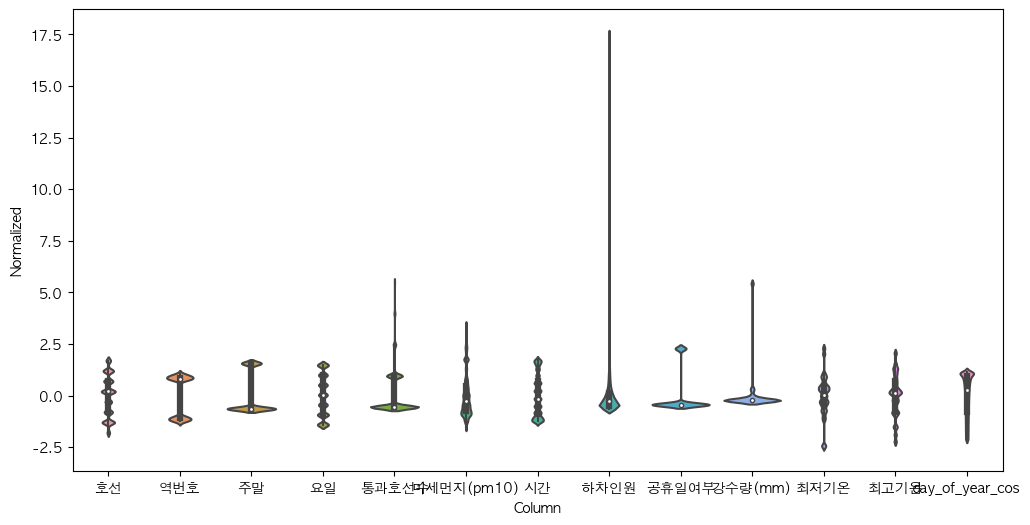

In [10]:
train_mean = df.mean()
train_std = df.std()
train_df = (df - train_mean) / train_std
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=0)

In [11]:
X = df.drop('하차인원', axis=1)
y = df['하차인원']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
print(X_train.shape)

#### keras Sequential model

In [25]:
keras_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

keras_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(patience = 10)
history = keras_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


/opt/anaconda3/envs/bus/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  self.activation = activations.get(activation)


3373/3373 ━━━━━━━━━━━━━━━━━━━━ 1s 335us/step - loss: 1223944.3750 - mae: 566.8365 - val_loss: 1023874.4375 - val_mae: 564.3676
Epoch 2/50
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 1s 309us/step - loss: 1011961.0000 - mae: 526.1476 - val_loss: 964245.7500 - val_mae: 519.3715
Epoch 3/50
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 1s 306us/step - loss: 1006511.8125 - mae: 520.4206 - val_loss: 956410.2500 - val_mae: 489.9028
Epoch 4/50
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 1s 307us/step - loss: 1008238.3125 - mae: 512.8881 - val_loss: 949019.3750 - val_mae: 493.7795
Epoch 5/50
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 1s 307us/step - loss: 936826.3750 - mae: 504.2859 - val_loss: 944810.5625 - val_mae: 518.4980
Epoch 6/50
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 1s 311us/step - loss: 944536.8125 - mae: 503.3975 - val_loss: 937940.7500 - val_mae: 486.7220
Epoch 7/50
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 1s 310us/step - loss: 976001.5000 - mae: 502.5541 - val_loss: 933006.1250 - val_mae: 487.0026
Epoch 8/50
3373/3373 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/ste

In [26]:
keras_model.evaluate(X_test,y_test)

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step - loss: 875482.6250 - mae: 477.5220


[839216.0, 468.69769287109375]

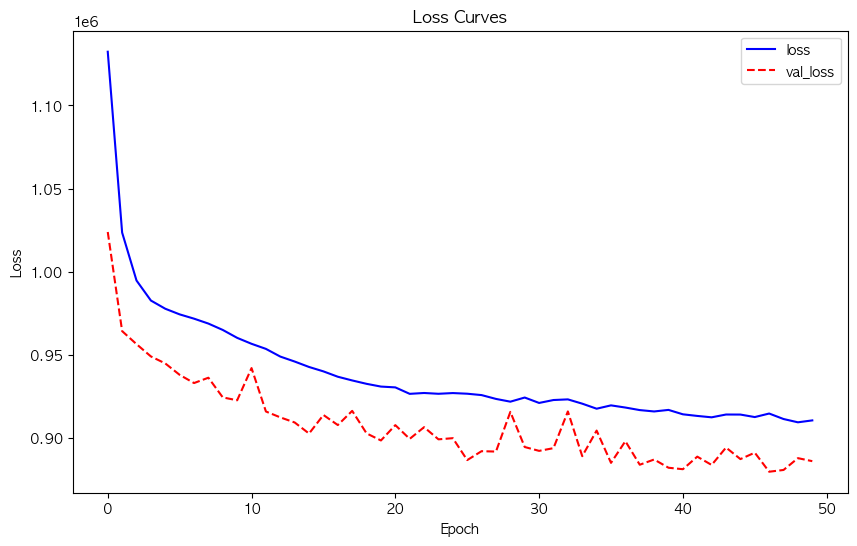

In [27]:
# 회귀 모델 학습 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [ ]:
keras_pred = keras_model.predict(X_test)

#### sklearn model

In [28]:
'''
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=20), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
# Best parameters: {'max_depth': 10, 'n_estimators': 200}
'''

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .....................max_depth=10, n_estimators=200; total time=  21.9s
[CV] END .....................max_depth=10, n_estimators=200; total time=  21.9s
[CV] END .....................max_depth=10, n_estimators=200; total time=  22.0s
[CV] END .....................max_depth=10, n_estimators=200; total time=  21.9s
[CV] END .....................max_depth=10, n_estimators=200; total time=  21.9s
Best parameters: {'max_depth': 10, 'n_estimators': 200}


In [42]:
best_rf_model = RandomForestRegressor(random_state=20, max_depth=10, n_estimators=200)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=20)

In [43]:
# 테스트 데이터로 성능 평가
rf_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, rf_pred)
mae = mean_absolute_error(y_test, rf_pred)
print(f"Test MSE: {mse}, Test MAE: {mae}")

Test MSE: 542893.0310089503, Test MAE: 357.51427718386566


In [32]:
lr_model = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

grid_search = GridSearchCV(lr_model, param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_

In [34]:
lr_pred = best_lr_model.predict(X_test)
score = r2_score(y_test, lr_pred)
mse = mean_squared_error(y_test, lr_pred)
mae = mean_absolute_error(y_test, lr_pred)
print(f"Best model score: {score:.2f}")
print(f"Test MSE: {mse}, Test MAE: {mae}")

Best model score: 0.12
Test MSE: 921787.6048955865, Test MAE: 523.4950876057787


#### total predict graph

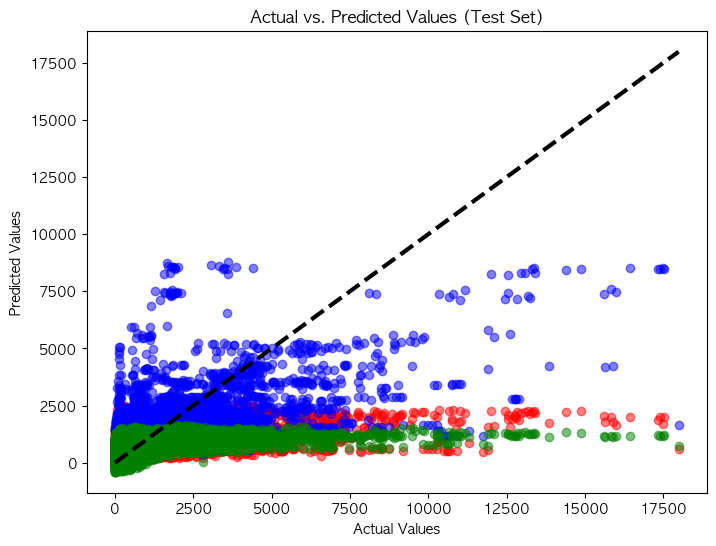

In [40]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, keras_pred, alpha=0.5, c='red')
plt.scatter(y_test, rf_pred, alpha=0.5, c='blue')
plt.scatter(y_test, lr_pred, alpha=0.5, c='green')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Test Set)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()